In [1]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [2]:
!pip install livelossplot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import PIL
from IPython.display import Image, display
from keras.applications.vgg16 import VGG16,preprocess_input
# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
import plotly.graph_objects as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


I'm gonna be using the jpeg files for training and testing.

In [4]:
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [5]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Since this is medical data I'm expecting it to be unbalanced.

In [6]:
train['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [7]:
labels=train['anatom_site_general_challenge'].value_counts().index
values=train['anatom_site_general_challenge'].value_counts().values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

In more than half of the patients in our dataset, the cancer is found on the torso.

Now if we look at the diagnosis provided by Dermatologists.(I have removed cases marked "unknown")

In [8]:
labels=train['diagnosis'].value_counts().index[1:]
values=train['diagnosis'].value_counts().values[1:]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

A "nevus" is basically a visible, circumscribed, chronic lesion of the skin. Since they are also called moles and also cover majority of the data, I think this diagnosis is for benign cases.

Let's check it out.

In [9]:
new=train.drop(labels=['image_name','patient_id','sex','age_approx','anatom_site_general_challenge','target'],axis=1)
pd.crosstab(new['diagnosis'].values,new['benign_malignant'])

benign_malignant,benign,malignant
row_0,,
atypical melanocytic proliferation,1,0
cafe-au-lait macule,1,0
lentigo NOS,44,0
lichenoid keratosis,37,0
melanoma,0,584
nevus,5193,0
seborrheic keratosis,135,0
solar lentigo,7,0
unknown,27124,0


> So my presumption was true and most benign cases are diagnosed as **nevus**. 

> All patients diagnosed as "melanoma" have malignant cancers. I think this term is only reserved for severe cases.

As I have already said the data is very imbalanced so I'll train on only a sample of it.

In [10]:
df_0=train[train['target']==0].sample(2000)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

Before going any further with training let's take a look at sample photos from both classes.

Benign Cases


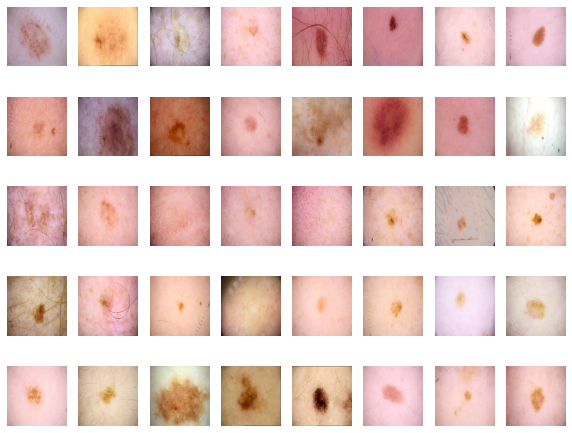

In [11]:
print('Benign Cases')
benign=[]
df_benign=df_0.sample(40)
df_benign=df_benign.reset_index()
for i in range(40):
    img=cv2.imread(str(train_dir + df_benign['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    benign.append(img)
f, ax = plt.subplots(5,8, figsize=(10,8))
for i, img in enumerate(benign):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

Malignant Cases


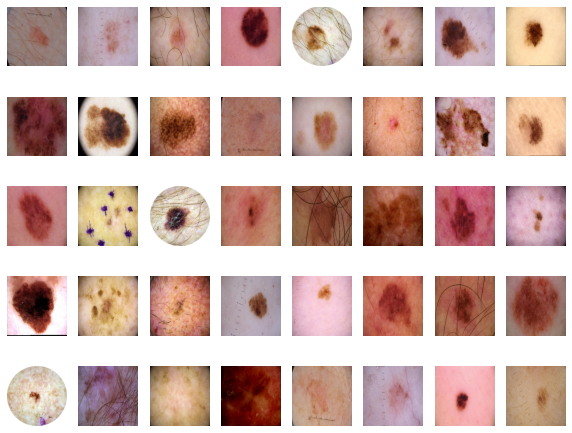

In [12]:
print('Malignant Cases')
malignant=[]
df_malignant=df_1.sample(40)
df_malignant=df_malignant.reset_index()
for i in range(40):
    img=cv2.imread(str(train_dir + df_malignant['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    malignant.append(img)
f, ax = plt.subplots(5,8, figsize=(10,8))
for i, img in enumerate(malignant):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

## Preparing the Datasets

In [13]:
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

In [14]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

In [15]:
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

I'll do some very basic preprocessing like 
* normalizing
* reshaping
* augmentation(only for train data)

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)

val_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    shuffle=False,
    batch_size=8,
    class_mode='raw')

Found 2067 validated image filenames.
Found 517 validated image filenames.


## Modelling
I'm using pretrained VGG-16 and adding the last dense layer.
The competition is evaluated on AUC scores, so we'll use that as a metric.

In [17]:
def vgg16_model( num_classes=None):

    model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x=Flatten()(model.output)
    output=Dense(1,activation='sigmoid')(x) # because we have to predict the AUC
    model=Model(model.input,output)
    
    return model

vgg_conv=vgg16_model(1)

58892288/58889256 [==============================] - 1s 0us/step


Also, because of class imbalance it's better to use **focal loss** rather than normal **binary_crossentropy**.You can read more about it [here](https://arxiv.org/abs/1708.02002)

In [18]:
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [19]:
opt = Adam(lr=1e-5)
vgg_conv.compile(loss=focal_loss(), metrics=[tf.keras.metrics.AUC()],optimizer=opt)

In [20]:
nb_epochs = 2
batch_size=8
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=validation.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 258 and 64


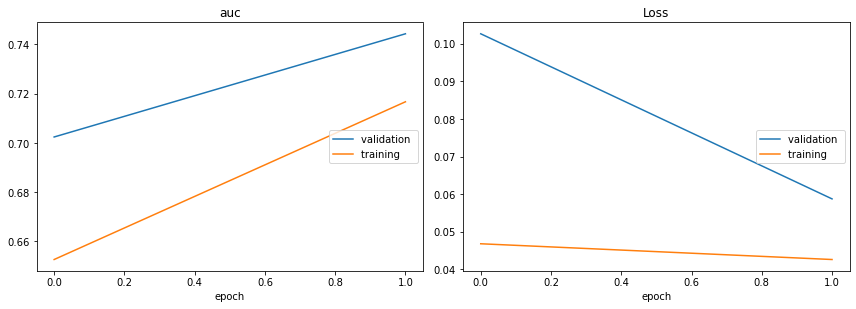

auc
	validation       	 (min:    0.702, max:    0.744, cur:    0.744)
	training         	 (min:    0.653, max:    0.717, cur:    0.717)
Loss
	validation       	 (min:    0.059, max:    0.103, cur:    0.059)
	training         	 (min:    0.043, max:    0.047, cur:    0.043)


In [21]:
cb=[PlotLossesKeras()]
vgg_conv.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=validation_generator,
    callbacks=cb,
    validation_steps=nb_val_steps)

## Submission

In [22]:
target=[]
for path in df_test['images']:
    img=cv2.imread(str(path))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    img=np.reshape(img,(1,224,224,3))
    prediction=vgg_conv.predict(img)
    target.append(prediction[0][0])

submission['target']=target

In [23]:
submission.to_csv('submission.csv', index=False)
submission.head()

,image_name,target
0,ISIC_0052060,0.194435
1,ISIC_0052349,0.121995
2,ISIC_0058510,0.103579
3,ISIC_0073313,0.107689
4,ISIC_0073502,0.308132


I'll keep on updating this kernel with new experiments.

If you liked it please upvote the kernel.